# Bitcoin confirmation safety

In [1]:
from scipy.stats import poisson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Calculation
The [Bitcoin whitepaper](https://bitcoin.org/bitcoin.pdf) shows the calculation in C. The Python version of that code is copied from  https://cyberleninka.org/article/n/1462435.pdf.

In [2]:
def C(q, z):
    if z < 0 or q >= 0.5: 
        prob = 1
    else: 
        prob = (q / (1 - q)) ** (z + 1)
    return prob

def P_N(q, m, n):
    return poisson.pmf(n, m * q / (1 - q))

In [3]:
def Nakamoto_DS_N(q, Z):
    return 1 - sum(P_N(q, Z, k) * (1 - C(q, Z - k - 1)) for k in range(0, Z + 1))

vNakamoto_DS_N = np.vectorize(Nakamoto_DS_N)

### Validation that the Python code produces the results that are shows in the [Bitcoin whitepaper](https://bitcoin.org/bitcoin.pdf)
Are the results on page 8 of the whitepaper the same as the ones we get from our calculations?
These are the q values that Satoshi shows for q=0.1 and q=0.3:

In [4]:
satoshiPfor_q0_1 = [1.0000000, # percentage of hashing power = 10%
0.2045873,
0.0509779,
0.0131722,
0.0034552,
0.0009137,
0.0002428,
0.0000647,
0.0000173,
0.0000046,
0.0000012]

satoshiPfor_q0_3 = [1.0000000, # percentage of hashing power = 30%
0.1773523,
0.0416605,
0.0101008,
0.0024804,
0.0006132,
0.0001522,
0.0000379,
0.0000095,
0.0000024,
0.0000006]

### Our calculation and results
Calculation of P - the probability of overtaking.

With 10% of the hashing power and 1..10 confirmations (steps of 1)

In [5]:
myPfor_q0_1 = vNakamoto_DS_N(0.1, np.arange(0, 11, 1))
myPfor_q0_1 = np.around(myPfor_q0_1, decimals=7)

display(myPfor_q0_1)

array([1.000000e+00, 2.045873e-01, 5.097790e-02, 1.317220e-02,
       3.455200e-03, 9.137000e-04, 2.428000e-04, 6.470000e-05,
       1.730000e-05, 4.600000e-06, 1.200000e-06])

Calculation of P - the probability of overtaking.

With 30% of the hashing power and 1..50 confirmations (steps of 5)

In [6]:
myPfor_q0_3 = vNakamoto_DS_N(0.3, np.arange(0, 55, 5))
myPfor_q0_3 = np.around(myPfor_q0_3, decimals=7)

display(myPfor_q0_3)

array([1.000000e+00, 1.773523e-01, 4.166050e-02, 1.010080e-02,
       2.480400e-03, 6.132000e-04, 1.522000e-04, 3.790000e-05,
       9.500000e-06, 2.400000e-06, 6.000000e-07])

Do we arrive at the same results as Nakamoto?

In [7]:
probFor10PercentEqual = np.array_equal(satoshiPfor_q0_1 ,myPfor_q0_1)
probFor30PercentEqual = np.array_equal(satoshiPfor_q0_3 ,myPfor_q0_3)
probFor10PercentEqual and probFor30PercentEqual

True

## How many confirmations are needed?

This graph shows the probability that an attacker could build the blocks for the confirmations plus an additional one faster than the honest nodes and thus providing the longest chain.
It is the same one as in [4 Validation](https://arxiv.org/abs/1701.03977). 

The formula Satoshi Nakamoto used in his [whitepaper](https://bitcoin.org/bitcoin.pdf) was about
>qz = probability the attacker will ever catch up...

See page 6.
This is the reason why we use `C(q, Z - k - 1)` in `Nakamoto_DS_N(q, Z)` to compare our results with those of Nakamoto.
But we want to see the probability of an attacker **overtaking** the honest nodes instead. This is why we changed the formular slightly to reach an additional block by using `C(q, Z - k)` in `Ozisik_Levine_DS_N(q, Z)`.
This aspect is also explained in [2.1.1 A Slight Variation of Gambler's Ruin](https://arxiv.org/abs/1701.03977). 

In [8]:
def Ozisik_Levine_DS_N(q, Z):
    return 1 - sum(P_N(q, Z, k) * (1 - C(q, Z - k)) for k in range(0, Z + 1))

vOzisik_Levine_DS_N = np.vectorize(Ozisik_Levine_DS_N)

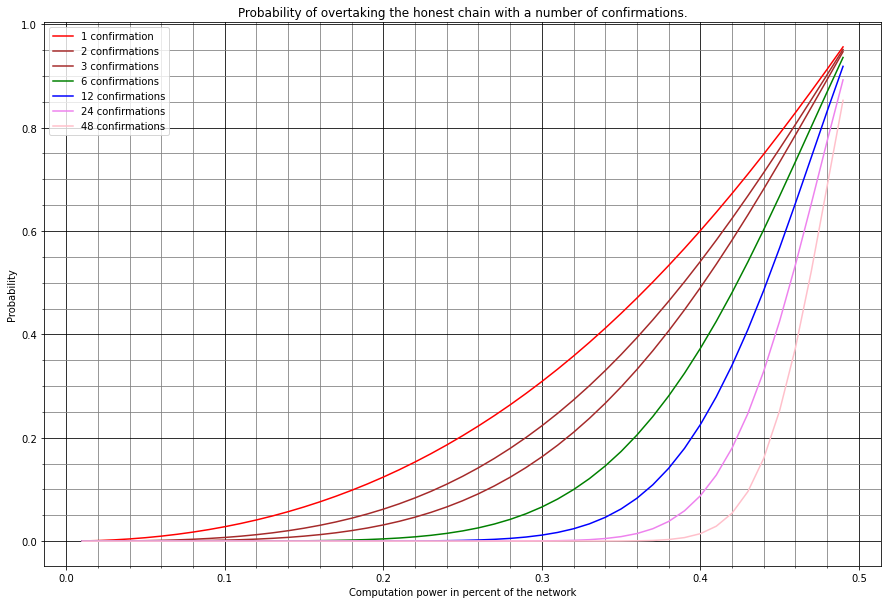

In [11]:
# The hashing power of the attacker = the probability the attacker will find the next block
q = np.arange(0.01, 0.5, 0.01) # 0.01..0.5 steps of 0.01

plt.rcParams['figure.figsize'] = [15, 10]

plt.title('Probability of overtaking the honest chain with a number of confirmations.')
plt.ylabel('Probability')
plt.xlabel('Computation power in percent of the network')
plt.minorticks_on()

plt.grid(b=True, which='major', color='black')
plt.grid(b=True, which='minor', color='gray')

plt.plot(q, vOzisik_Levine_DS_N(q, 1), 'r', label="1 confirmation")
plt.plot(q, vOzisik_Levine_DS_N(q, 2), 'brown', label="2 confirmations")
plt.plot(q, vOzisik_Levine_DS_N(q, 3), 'brown', label="3 confirmations")
plt.plot(q, vOzisik_Levine_DS_N(q, 6), 'green', label="6 confirmations")
plt.plot(q, vOzisik_Levine_DS_N(q, 12), 'blue', label="12 confirmations")
plt.plot(q, vOzisik_Levine_DS_N(q, 24), 'violet', label="24 confirmations")
plt.plot(q, vOzisik_Levine_DS_N(q, 48), 'pink', label="48 confirmations")

plt.legend()